# Datasets Overview

This project utilizes five datasets from Kaggle, providing comprehensive information on popular streaming platforms and IMDb ratings. Each dataset is updated daily, ensuring accurate and relevant content.

1. **Netflix**

    * Source: [Netflix Movies & TV Series Dataset](https://www.kaggle.com/datasets/octopusteam/full-netflix-dataset)
    * **Description**: A complete collection of Netflix's available titles (movies and TV series) with IMDb-specific data such as IMDb ID, average rating, and number of votes.

2. **Apple TV+**

    * Source: [Full Apple TV+ Dataset](https://www.kaggle.com/datasets/octopusteam/full-apple-tv-dataset)
    * Description: A dataset covering all Apple TV+ titles, including key IMDb data for in-depth analysis of content quality.

3. **HBO Max**

    * Source:  [Full HBO Max Dataset](https://www.kaggle.com/datasets/octopusteam/full-hbo-max-dataset)
    * Description: An extensive collection of titles on HBO Max with associated IMDb data for comparison.

3. **Amazon Prime**

   * Source: [Full Amazon Prime Dataset](https://www.kaggle.com/datasets/octopusteam/full-amazon-prime-dataset)
    * Description: Comprehensive data on Amazon Prime's movie and TV series offerings, including IMDb-specific metrics.

4. **Hulu**

    * Source: [Full Hulu Dataset](https://www.kaggle.com/datasets/octopusteam/full-hulu-dataset)
    * Description: A dataset detailing Hulu's catalog with IMDb-related columns for evaluating content quality and popularity.

Each of the streaming platform datasets includes the following columns:

* **title**: Name of the content.
* **type**: Either "movie" or "tv series."
* **genres**: Genres associated with the title.
* **releaseYear**: Year the title was released.
* **imdbId**: Unique IMDb identifier.
* **imdbAverageRating**: Average user rating on IMDb.
* **imdbNumVotes**: Number of votes received on IMDb.
* **availableCountries**: Countries where the title is available.

# Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load Datasets

In [2]:
# Define the base path
base_path = r"C:\Users\kimbe\Documents\StreamingAnalysis\data\raw_data"

# Load the datasets
amazon_df = pd.read_csv(f'{base_path}\\amazon_catalog.csv')
hulu_df = pd.read_csv(f'{base_path}\\hulu_catalog.csv')
netflix_df = pd.read_csv(f'{base_path}\\netflix_catalog.csv')
hbo_df = pd.read_csv(f'{base_path}\\hbo_catalog.csv')
apple_df = pd.read_csv(f'{base_path}\\apple_catalog.csv')

# Platform Info
platforms = ['Amazon', 'Hulu', 'Netflix', 'HBO', 'Apple']
platform_dfs = [amazon_df, hulu_df, netflix_df, hbo_df, apple_df]


# Custom Functions

Percent of rows missing imdbId and drop them

In [3]:
# Calculate the percentage of rows with missing imdbId
def calculate_missing_percent_and_clean(datasets, platforms):
    missing_percentages = []

    for platform, df in zip(platforms, datasets):
        # Calculate the percentage of missing imdbId
        missing_count = df["imdbId"].isnull().sum()
        total_count = len(df)
        missing_percentage = (missing_count / total_count) * 100

        # Store the platform and percentage
        missing_percentages.append({"Platform": platform, "Missing Percent": missing_percentage})

        # Remove rows with missing imdbId
        datasets[platforms.index(platform)] = df.dropna(subset=["imdbId"]).reset_index(drop=True)

    # Create a DataFrame for the missing percentages
    missing_df = pd.DataFrame(missing_percentages).sort_values(by="Missing Percent", ascending=False)

    return missing_df, datasets

Display a table with the column name, datatype, a random non-null value, and the number of missing values for each column

In [4]:
def summarize_columns(df):
    summary = []
    for column in df.columns:
        column_dtype = df[column].dtype
        
        # Find a random row with no null values
        non_null_rows = df.dropna()
        random_row = non_null_rows.sample(1).iloc[0]
        random_non_null_value = random_row[column]

        missing_values_count = df[column].isnull().sum()
        summary.append([column, column_dtype, random_non_null_value, missing_values_count])

    summary_df = pd.DataFrame(summary, columns=['Column Name', 'Data Type', 'Random Non-Null Value', 'Missing Values Count'])
    return summary_df

Print unique values in the dataset and number of them

In [5]:
def print_unique_values(df, column_name):
    """Prints all unique values in a specified column of a DataFrame.

    Args:
        df: The DataFrame to analyze.
        column_name: The name of the column to check.
    """
    unique_values = df[column_name].unique()
    print(f"Unique values in column '{column_name}':")
    print(unique_values)

Drop rows without US but first count and store the numbers

In [6]:
def availability_split(datasets, platforms):
    availability_data = []
    cleaned_datasets = {}  # To store cleaned datasets
    
    for platform, df in zip(platforms, datasets):
        # Count rows with "US"
        us_rows = df[df['availableCountries'].str.contains('US', na=False)]
        non_us_rows = df[~df['availableCountries'].str.contains('US', na=False)]
        
        # Calculate percentages
        total_rows = len(df)
        us_count = len(us_rows)
        us_percentage = (us_count / total_rows) * 100 if total_rows > 0 else 0
        
        # Store availability data (only required columns)
        availability_data.append({
            'Platform': platform,
            'Number of US Titles': us_count,
            'US Percentage': us_percentage
        })
        
        # Save the cleaned dataset for this platform (optional, based on your needs)
        cleaned_datasets[platform] = us_rows.reset_index(drop=True)
    
    # Create a DataFrame for availability data
    availability_df = pd.DataFrame(availability_data)
    
    # Sort by US Percentage (optional for visualization)
    availability_df = availability_df.sort_values(by='US Percentage', ascending=False)
    
    # Create the plot with better styling
    plt.figure(figsize=(14, 8))  # Increase figure size for better readability
    
    # Plot bar chart (not stacked since we're only showing US Percentage)
    ax = availability_df.plot(kind='bar', x='Platform', y='US Percentage',
                              color='#4C8BF5', width=0.75, edgecolor='white', legend=False)
    
    # Add titles and labels
    plt.title('Content Availability: U.S. for Each Platform', fontsize=18, weight='bold', color='#333')
    plt.xlabel('Platform', fontsize=14, color='#555')
    plt.ylabel('US Percentage (%)', fontsize=14, color='#555')
    
    # Customize x-axis tick labels
    plt.xticks(rotation=45, ha='right', fontsize=12, color='#555')
    
    # Add data labels on top of the bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=11, color='#333', fontweight='bold')
    
    # Adjust layout to make sure everything fits (including title and labels)
    plt.tight_layout()
    
    # Save the plot as a PNG file
    output_path = r'C:\Users\kimbe\Documents\StreamingAnalysis\outputs\us_availability.png'
    plt.savefig(output_path, dpi=300)
    plt.close()  # Close the plot to prevent overwriting
    
    print(f"Saved content availability visualization as PNG at: {output_path}")
    
    return availability_df, cleaned_datasets


Add a new column with the platform name and fill with 1

In [7]:
# Function to add platform-specific column to each dataset
def add_platform_column(df, platform_name):
    df[platform_name] = 1  # Mark all rows as available in the platform
    return df

Merge platform datasets on imdbId and handle NaN for availability

In [8]:

# Function to merge platform datasets on imdbId and handle NaN for availability
def merge_platform_datasets(platforms, platform_dfs):
    
    # Combine all datasets into a single dataframe
    all_platforms = pd.concat(platform_dfs, ignore_index=True)
    
    # Perform the groupby operation with custom aggregation logic
    merged_df = all_platforms.groupby('imdbId', as_index=False).agg({
        'type': 'first',        # Take the first non-null value
        'genres': 'first',      # Take the first non-null value
        'releaseYear': 'first', # Take the first non-null value
        'title': 'first',       # Take the first non-null value
        'imdbAverageRating': 'first',
        'imdbNumVotes': 'first',
        **{platform: 'max' for platform in platforms}  # Max will consolidate availability across datasets
    })
    
    # Replace NaN values in platform-specific columns with 0 and ensure binary representation (0 or 1)
    for platform in platforms:
        merged_df[platform] = merged_df[platform].fillna(0).astype(int)  # Modify directly and assign
    
    return merged_df

Count missing values with percentages

In [9]:
def count_missing_values(df):
    # Calculate missing values and percentages
    missing_counts = df.isnull().sum()
    missing_percentage = (df.isnull().mean() * 100).round(2)
    
    # Create the summary DataFrame
    missing_summary = pd.DataFrame({
        'Missing Values': missing_counts,
        'Percentage (%)': missing_percentage.astype(str) + '%'
    })
    
    return missing_summary

# Combine Platforms

Remove rows where imdbID is null

In [10]:
# Count the number of rows missing IMDbID and remove them
missing_percent_df, cleaned_datasets = calculate_missing_percent_and_clean(platform_dfs, platforms)

# Display the missing percentages
missing_percent_df

,Platform,Missing Percent
1,Hulu,9.307972
0,Amazon,8.441807
4,Apple,7.342813
2,Netflix,6.437875
3,HBO,5.236838


Remove rows where not in US, count and save to csv

In [11]:
# Create an empty Comparison DataFrame
comparison_df = pd.DataFrame(columns=[
    'Platform', 
    'Total Titles', 
    'US Titles', 
    'US Percentage', 
    'Non-US Titles', 
    'Non-US Percentage'
])

In [12]:
# Call the function
availability_df, cleaned_datasets = availability_split(platform_dfs, platforms)

# Initialize comparison_df if it doesn't already exist
try:
    comparison_df = pd.read_csv(r'C:\Users\kimbe\Documents\StreamingAnalysis\outputs\comparison_data.csv')
except FileNotFoundError:
    # Create an empty comparison DataFrame with the required columns
    comparison_df = pd.DataFrame(columns=['Platform', 'Number of US Titles', 'US Percentage'])

# Remove any empty or all-NA columns from availability_df (optional)
availability_df = availability_df.dropna(how='all', axis=1)

# Concatenate the DataFrames, ensuring only the required columns are included
comparison_df = pd.concat([comparison_df, availability_df[['Platform', 'Number of US Titles', 'US Percentage']]], ignore_index=True)

# Ensure the 'US Percentage' column is numeric before formatting
comparison_df['US Percentage'] = pd.to_numeric(comparison_df['US Percentage'], errors='coerce')

# Format the 'US Percentage' as a string with two decimal places and a '%' sign
comparison_df['US Percentage'] = comparison_df['US Percentage'].apply(lambda x: f'{x:.2f}%' if pd.notnull(x) else 'NaN')

# Save the updated Comparison DataFrame
comparison_path = r'C:\Users\kimbe\Documents\StreamingAnalysis\outputs\comparison_data.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"Updated Comparison DataFrame saved at: {comparison_path}")


Saved content availability visualization as PNG at: C:\Users\kimbe\Documents\StreamingAnalysis\outputs\us_availability.png
Updated Comparison DataFrame saved at: C:\Users\kimbe\Documents\StreamingAnalysis\outputs\comparison_data.csv


C:\Users\kimbe\AppData\Local\Temp\ipykernel_31656\2470135220.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_df = pd.concat([comparison_df, availability_df[['Platform', 'Number of US Titles', 'US Percentage']]], ignore_index=True)


<Figure size 1400x800 with 0 Axes>

Add a new column with the platform name and fill with 1

In [13]:
# Apply the function for each platform dataset
for platform_name, df in zip(platforms, platform_dfs):
    add_platform_column(df, platform_name)
    
    

In [14]:
# Check that it worked
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20193 entries, 0 to 20192
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               19679 non-null  object 
 1   type                20193 non-null  object 
 2   genres              19924 non-null  object 
 3   releaseYear         20178 non-null  float64
 4   imdbId              18893 non-null  object 
 5   imdbAverageRating   18742 non-null  float64
 6   imdbNumVotes        18742 non-null  float64
 7   availableCountries  20193 non-null  object 
dtypes: float64(3), object(5)
memory usage: 1.2+ MB


Merge the platforms on imdbId

In [15]:
# Merge the datasets
merged_platforms = merge_platform_datasets(platforms, platform_dfs)

In [16]:
merged_platforms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92049 entries, 0 to 92048
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdbId             92049 non-null  object 
 1   type               92049 non-null  object 
 2   genres             91804 non-null  object 
 3   releaseYear        92044 non-null  float64
 4   title              92049 non-null  object 
 5   imdbAverageRating  89179 non-null  float64
 6   imdbNumVotes       89179 non-null  float64
 7   Amazon             92049 non-null  int64  
 8   Hulu               92049 non-null  int64  
 9   Netflix            92049 non-null  int64  
 10  HBO                92049 non-null  int64  
 11  Apple              92049 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.4+ MB


Remove release year where outside of 1898 - 2024

In [17]:
merged_platforms = merged_platforms[(merged_platforms['releaseYear'] >= 1898) & (merged_platforms['releaseYear'] <= 2024)]

Extract imdbIds

In [18]:
# Extract unique IMDb IDs from merged_platforms
imdb_ids_in_platforms = merged_platforms['imdbId'].unique()

# Convert to a DataFrame
imdb_ids_in_platforms_df = pd.DataFrame(imdb_ids_in_platforms, columns=['imdbId'])

# Save to CSV for use in other notebooks
imdb_ids_in_platforms_df.to_csv(r'C:\Users\kimbe\Documents\StreamingAnalysis\data\imdb_ids_in_platforms.csv', index=False)
print("imdb_ids_in_platforms saved as CSV.")


imdb_ids_in_platforms saved as CSV.


In [19]:
# Path to the saved filtered IMDb info CSV
filtered_imdb_info_path = r'C:\Users\kimbe\Documents\StreamingAnalysis\data\filtered_imdb_info.csv'

# Load the filtered IMDb info into a DataFrame
filtered_imdb_info = pd.read_csv(filtered_imdb_info_path)

# Display information about the loaded DataFrame
print(f"Filtered IMDb info loaded with {len(filtered_imdb_info)} rows and {filtered_imdb_info.shape[1]} columns.")
filtered_imdb_info.head()

Filtered IMDb info loaded with 89159 rows and 11 columns.


,imdbId,type,title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000417,short,A Trip to the Moon,Le voyage dans la lune,0.0,1902.0,NaN,13.0,"Adventure,Comedy,Fantasy",8.1,57373
1,tt0000499,short,An Impossible Voyage,Le voyage à travers l'impossible,0.0,1904.0,NaN,24.0,"Action,Adventure,Family",7.5,4153
2,tt0002646,movie,Atlantis,Atlantis,0.0,1913.0,NaN,121.0,Drama,6.5,502
3,tt0003014,movie,Ingeborg Holm,Ingeborg Holm,0.0,1913.0,NaN,96.0,Drama,7.0,1479
4,tt0004181,movie,Judith of Bethulia,Judith of Bethulia,0.0,1914.0,NaN,61.0,Drama,6.2,1482


In [20]:
count_missing_values(filtered_imdb_info)

,Missing Values,Percentage (%)
imdbId,0,0.0%
type,0,0.0%
title,0,0.0%
originalTitle,0,0.0%
isAdult,0,0.0%
startYear,5,0.01%
endYear,79461,89.12%
runtimeMinutes,6814,7.64%
genres,605,0.68%
averageRating,0,0.0%


In [21]:
filtered_imdb_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89159 entries, 0 to 89158
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   imdbId          89159 non-null  object 
 1   type            89159 non-null  object 
 2   title           89159 non-null  object 
 3   originalTitle   89159 non-null  object 
 4   isAdult         89159 non-null  float64
 5   startYear       89154 non-null  float64
 6   endYear         9698 non-null   float64
 7   runtimeMinutes  82345 non-null  float64
 8   genres          88554 non-null  object 
 9   averageRating   89159 non-null  float64
 10  numVotes        89159 non-null  int64  
dtypes: float64(5), int64(1), object(5)
memory usage: 7.5+ MB


# Investigate missing genres

In [22]:
count_missing_values(merged_platforms)

,Missing Values,Percentage (%)
imdbId,0,0.0%
type,0,0.0%
genres,245,0.27%
releaseYear,0,0.0%
title,0,0.0%
imdbAverageRating,2857,3.1%
imdbNumVotes,2857,3.1%
Amazon,0,0.0%
Hulu,0,0.0%
Netflix,0,0.0%


In [23]:
merged_platforms.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92036 entries, 0 to 92048
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdbId             92036 non-null  object 
 1   type               92036 non-null  object 
 2   genres             91791 non-null  object 
 3   releaseYear        92036 non-null  float64
 4   title              92036 non-null  object 
 5   imdbAverageRating  89179 non-null  float64
 6   imdbNumVotes       89179 non-null  float64
 7   Amazon             92036 non-null  int64  
 8   Hulu               92036 non-null  int64  
 9   Netflix            92036 non-null  int64  
 10  HBO                92036 non-null  int64  
 11  Apple              92036 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.1+ MB


Merge Using imdbId: Use an inner join to combine filtered_imdb_info with merged_platforms based on imdbId.

In [24]:
final_df = pd.merge(
    merged_platforms,
    filtered_imdb_info,
    on='imdbId',
    suffixes=('_platform', '_imdb')
)
print(final_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89159 entries, 0 to 89158
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdbId             89159 non-null  object 
 1   type_platform      89159 non-null  object 
 2   genres_platform    89004 non-null  object 
 3   releaseYear        89159 non-null  float64
 4   title_platform     89159 non-null  object 
 5   imdbAverageRating  89156 non-null  float64
 6   imdbNumVotes       89156 non-null  float64
 7   Amazon             89159 non-null  int64  
 8   Hulu               89159 non-null  int64  
 9   Netflix            89159 non-null  int64  
 10  HBO                89159 non-null  int64  
 11  Apple              89159 non-null  int64  
 12  type_imdb          89159 non-null  object 
 13  title_imdb         89159 non-null  object 
 14  originalTitle      89159 non-null  object 
 15  isAdult            89159 non-null  float64
 16  startYear          891

Check for Duplicates: After merging, ensure there are no duplicate rows based on imdbId.


In [25]:
final_df = final_df.drop_duplicates(subset='imdbId').reset_index(drop=True)
print(f"After deduplication: {len(final_df)} rows")


After deduplication: 89159 rows


Merge genres and types

In [26]:
# Merge genres columns: prioritize genres_imdb, fallback to genres_platform
final_df['genres'] = final_df['genres_imdb'].combine_first(final_df['genres_platform'])

# Merge type columns: prioritize type_imdb, fallback to type_platform
final_df['type'] = final_df['type_imdb'].combine_first(final_df['type_platform'])

# Drop the old redundant columns to clean the DataFrame
final_df
# Display the updated DataFrame
print(final_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89159 entries, 0 to 89158
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdbId             89159 non-null  object 
 1   type_platform      89159 non-null  object 
 2   genres_platform    89004 non-null  object 
 3   releaseYear        89159 non-null  float64
 4   title_platform     89159 non-null  object 
 5   imdbAverageRating  89156 non-null  float64
 6   imdbNumVotes       89156 non-null  float64
 7   Amazon             89159 non-null  int64  
 8   Hulu               89159 non-null  int64  
 9   Netflix            89159 non-null  int64  
 10  HBO                89159 non-null  int64  
 11  Apple              89159 non-null  int64  
 12  type_imdb          89159 non-null  object 
 13  title_imdb         89159 non-null  object 
 14  originalTitle      89159 non-null  object 
 15  isAdult            89159 non-null  float64
 16  startYear          891

Check votes and drop

In [27]:
# Columns to check
columns_to_check = ['imdbAverageRating', 'imdbNumVotes', 'averageRating', 'numVotes']

# Check for null values and calculate percentages
null_summary = final_df[columns_to_check].isnull().sum().reset_index()
null_summary.columns = ['Column', 'Missing Values']
null_summary['Percentage (%)'] = (null_summary['Missing Values'] / len(final_df)) * 100

# Display the null value summary
print(null_summary)


              Column  Missing Values  Percentage (%)
0  imdbAverageRating               3        0.003365
1       imdbNumVotes               3        0.003365
2      averageRating               0        0.000000
3           numVotes               0        0.000000


In [28]:
# Drop rows with missing values in the specified columns
final_df = final_df.dropna(subset=['imdbAverageRating', 'imdbNumVotes'])

# Verify the change
print(f"Number of rows after dropping: {len(final_df)}")


Number of rows after dropping: 89156


In [29]:
final_df.head().T

,0,1,2,3,4
imdbId,tt0000417,tt0000499,tt0002646,tt0003014,tt0004181
type_platform,movie,movie,movie,movie,movie
genres_platform,"Action, Adventure, Comedy","Action, Adventure, Family",Drama,Drama,Drama
releaseYear,1902.0,1904.0,1913.0,1913.0,1914.0
title_platform,A Trip to the Moon,An Impossible Voyage,Atlantis,Ingeborg Holm,Judith of Bethulia
imdbAverageRating,8.1,7.5,6.5,7.0,6.2
imdbNumVotes,57365.0,4153.0,502.0,1479.0,1482.0
Amazon,1,0,1,0,1
Hulu,0,0,0,0,0
Netflix,0,0,0,1,0


In [30]:
count_missing_values(final_df)

,Missing Values,Percentage (%)
imdbId,0,0.0%
type_platform,0,0.0%
genres_platform,155,0.17%
releaseYear,0,0.0%
title_platform,0,0.0%
imdbAverageRating,0,0.0%
imdbNumVotes,0,0.0%
Amazon,0,0.0%
Hulu,0,0.0%
Netflix,0,0.0%


# Clean up final dataset

Rename and change datatypes

In [31]:
# Print the datatypes of each column
print("Data Types:")
print(final_df.dtypes)

# Display a random sample of 5 rows to inspect the data
print("\nSample Data:")
final_df.sample(5)

Data Types:
imdbId                object
type_platform         object
genres_platform       object
releaseYear          float64
title_platform        object
imdbAverageRating    float64
imdbNumVotes         float64
Amazon                 int64
Hulu                   int64
Netflix                int64
HBO                    int64
Apple                  int64
type_imdb             object
title_imdb            object
originalTitle         object
isAdult              float64
startYear            float64
endYear              float64
runtimeMinutes       float64
genres_imdb           object
averageRating        float64
numVotes               int64
genres                object
type                  object
dtype: object

Sample Data:


,imdbId,type_platform,genres_platform,releaseYear,title_platform,imdbAverageRating,imdbNumVotes,Amazon,Hulu,Netflix,...,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_imdb,averageRating,numVotes,genres,type
27480,tt1024663,movie,Documentary,2004.0,Rape in a Small Town: The Florence Holway Story,7.3,144.0,0,0,0,...,Rape in a Small Town: The Florence Holway Story,0.0,2004.0,NaN,73.0,Documentary,7.3,144,Documentary,tvMovie
16869,tt0238380,movie,"Action, Drama, Sci-Fi",2002.0,Equilibrium,7.3,351812.0,1,1,0,...,Equilibrium,0.0,2002.0,NaN,107.0,"Action,Drama,Sci-Fi",7.3,351843,"Action,Drama,Sci-Fi",movie
4908,tt0065375,movie,"Adventure, Comedy, History",1970.0,The Adventures of Gerard,4.8,381.0,1,0,0,...,The Adventures of Gerard,0.0,1970.0,NaN,92.0,"Adventure,Comedy,History",4.8,381,"Adventure,Comedy,History",movie
53707,tt22022560,tv,Documentary,2022.0,Saving the King,7.2,526.0,0,0,0,...,Salvar al rey,0.0,2022.0,2022.0,NaN,Documentary,7.2,526,Documentary,tvSeries
40593,tt14390092,movie,"Comedy, Drama",2022.0,North of the 10,4.7,148.0,0,0,0,...,North of the 10,0.0,2022.0,NaN,154.0,"Comedy,Drama",4.7,148,"Comedy,Drama",movie


In [32]:
# Drop unnecessary columns
final_df.drop(columns=['startYear', 'endYear', 'runtimeMinutes', 'originalTitle', 'title_platform', 'isAdult', 'averageRating','numVotes'], inplace=True)

# Rename 'title_imdb' to 'title'
final_df.rename(columns={'title_imdb': 'title'}, inplace=True)

# Check datatypes and ensure they are as expected
final_df['releaseYear'] = final_df['releaseYear'].astype(int)  # Ensure it's an integer
final_df['imdbAverageRating'] = final_df['imdbAverageRating'].astype(float)
final_df['imdbNumVotes'] = final_df['imdbNumVotes'].astype(int)

# Sample the data to confirm changes
print(final_df.dtypes)
final_df.sample(5)

imdbId                object
type_platform         object
genres_platform       object
releaseYear            int64
imdbAverageRating    float64
imdbNumVotes           int64
Amazon                 int64
Hulu                   int64
Netflix                int64
HBO                    int64
Apple                  int64
type_imdb             object
title                 object
genres_imdb           object
genres                object
type                  object
dtype: object


,imdbId,type_platform,genres_platform,releaseYear,imdbAverageRating,imdbNumVotes,Amazon,Hulu,Netflix,HBO,Apple,type_imdb,title,genres_imdb,genres,type
56678,tt24132650,movie,"Comedy, Romance",2017,7.0,55,0,0,1,0,0,movie,Thi Baan the Series,"Comedy,Romance","Comedy,Romance",movie
25467,tt0838231,movie,"Drama, Romance",2007,6.8,1316,1,0,0,0,0,movie,Unfinished Sky,"Drama,Romance","Drama,Romance",movie
80369,tt7087016,movie,Drama,2018,4.4,88,1,0,0,0,0,movie,American Martyr,Drama,Drama,movie
47243,tt1727300,movie,"Comedy, Drama, Music",2011,6.2,1358,1,0,0,0,0,movie,Hunky Dory,"Comedy,Drama,Music","Comedy,Drama,Music",movie
36751,tt13132466,movie,Drama,2021,5.4,79,1,0,0,0,0,movie,There's Always Hope,Drama,Drama,movie


In [33]:
# Rearrange columns in a more logical order
new_column_order = [
    'imdbId', 'title', 'releaseYear', 'genres', 'type',
    'imdbAverageRating', 'imdbNumVotes',
    'Amazon', 'Hulu', 'Netflix', 'HBO', 'Apple'
]

# Reorder the DataFrame columns
final_df = final_df[new_column_order]

# Check for duplicates
duplicates = final_df.duplicated().sum()

# Remove duplicates
final_df = final_df.drop_duplicates()

# Sample the data and check duplicates
print(f"Number of duplicates: {duplicates}")
final_df.sample(5)


Number of duplicates: 0


,imdbId,title,releaseYear,genres,type,imdbAverageRating,imdbNumVotes,Amazon,Hulu,Netflix,HBO,Apple
27768,tt10323168,Devaki,2019,Thriller,movie,5.3,129,1,0,0,0,0
80117,tt7008872,Boy Erased,2018,"Biography,Drama",movie,6.9,44315,1,0,1,0,1
26098,tt0920459,The Happy Housewife,2010,"Comedy,Drama,Romance",movie,6.7,3015,0,0,1,0,0
82475,tt7690214,Tya Ratri Paus Hota,2009,Drama,movie,7.3,29,1,0,0,0,0
33700,tt1202540,Dil Bole Hadippa,2009,"Comedy,Drama,Romance",movie,4.7,4771,1,0,0,0,0


In [34]:
print(final_df.dtypes)

imdbId                object
title                 object
releaseYear            int64
genres                object
type                  object
imdbAverageRating    float64
imdbNumVotes           int64
Amazon                 int64
Hulu                   int64
Netflix                int64
HBO                    int64
Apple                  int64
dtype: object


In [35]:
count_missing_values(final_df)

,Missing Values,Percentage (%)
imdbId,0,0.0%
title,0,0.0%
releaseYear,0,0.0%
genres,155,0.17%
type,0,0.0%
imdbAverageRating,0,0.0%
imdbNumVotes,0,0.0%
Amazon,0,0.0%
Hulu,0,0.0%
Netflix,0,0.0%


Investigate patterns with genres 

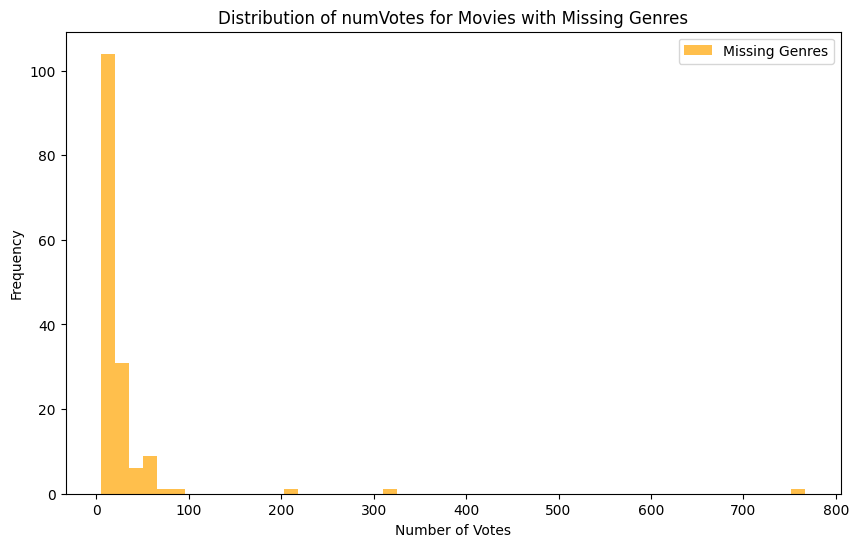

In [36]:
# Filter rows where genres are missing
enriched_data = final_df [final_df ['genres'].isna()]

# Plot the distribution of numVotes for rows with missing genres
plt.figure(figsize=(10, 6))
plt.hist(enriched_data['imdbNumVotes'], bins=50, alpha=0.7, color='orange', label='Missing Genres')

# Add labels and title
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of numVotes for Movies with Missing Genres')

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.show()


Drop rows with missing genre

In [37]:
# Drop rows where genres are missing
final_df = final_df.dropna(subset=['genres'])

# Verify the number of rows after dropping missing genres
print(f"Number of entries after dropping rows with missing genres: {len(final_df)}")


Number of entries after dropping rows with missing genres: 89001


In [38]:
print_unique_values(final_df, 'type')

Unique values in column 'type':
['short' 'movie' 'tvSeries' 'tvMovie' 'tvEpisode' 'tvMiniSeries' 'tvShort'
 'video' 'tvSpecial' 'videoGame']


Combine the values in the 'type' column into two categories: "movie" and "tv show"

In [39]:
def combine_type_column(df):
    """Combines 'type' column into 'movie' and 'tv show' categories."""
    tv_show_types = ['tvSeries', 'tvMiniSeries', 'tvSpecial', 'tvMovie']
    df['type'] = df['type'].apply(lambda x: 'tv show' if x in tv_show_types else 'movie')

# Example usage
combine_type_column(final_df)

# Verify the result
print_unique_values(final_df, 'type')

Unique values in column 'type':
['movie' 'tv show']


In [40]:
# Convert the genres column to lists if not already
final_df['genres'] = final_df['genres'].str.split(',')

# Clean and sort each genre group to standardize representation
final_df['genres'] = final_df['genres'].apply(lambda x: [genre.strip() for genre in x] if isinstance(x, list) else [])

# Flatten the list of all genre groups into individual groups and count occurrences
all_genre_groups = final_df['genres'].apply(tuple)  # Convert to tuple for immutability
genre_group_counts = all_genre_groups.value_counts()

# Create a DataFrame with the unique genre groups and their counts
unique_genre_groups_df = pd.DataFrame({
    'Genre Group': ['/'.join(group) for group in genre_group_counts.index],
    'Count': genre_group_counts.values
})

# Save to CSV
output_path = r"C:\Users\kimbe\Documents\StreamingAnalysis\outputs\unique_genres_groups.csv"
unique_genre_groups_df.to_csv(output_path, index=False)
print(f"Unique genre groups and their counts saved to: {output_path}")


Unique genre groups and their counts saved to: C:\Users\kimbe\Documents\StreamingAnalysis\outputs\unique_genres_groups.csv


In [41]:
# Define the file path
file_path = r"C:\Users\kimbe\Documents\StreamingAnalysis\data\cleaned_data\final_df.csv"

# Save the dataframe to a CSV file
final_df.to_csv(file_path, index=False)

print(f"Data saved to {file_path}")


Data saved to C:\Users\kimbe\Documents\StreamingAnalysis\data\cleaned_data\final_df.csv


One hot encode genres

In [42]:
# Standardize genres
genre_replacements = {
    'Reality': 'Reality-TV', 
    'Adult': None,  
    'Sci-Fi': 'Science Fiction', 
    'Action & Adventure': None,
    'Kids': None,
    'Soap': None,
    'Film Noir': None
}

# Apply the genre replacements to the genres column
final_df['genres'] = final_df['genres'].apply(lambda x: [genre_replacements.get(genre, genre) for genre in x])

# Remove any genres that were marked for removal (i.e., 'None')
final_df['genres'] = final_df['genres'].apply(lambda x: [genre for genre in x if genre is not None])

# Flatten the genres column and get the count of each unique genre
all_genres = final_df['genres'].explode().value_counts()

# Calculate the percentage
total_rows = len(final_df)
percentage = (all_genres / total_rows) * 100

# Combine the count and percentage into a DataFrame
genre_summary = pd.DataFrame({
    'count': all_genres,
    'percentage': percentage
}).reset_index()

# Rename columns for clarity
genre_summary.columns = ['genre', 'count', 'percentage']

# Display the result
print(genre_summary)


              genre  count  percentage
0             Drama  40234   45.206234
1            Comedy  24966   28.051370
2            Action  13067   14.681858
3           Romance  11193   12.576263
4             Crime  10996   12.354917
5          Thriller  10907   12.254918
6       Documentary  10841   12.180762
7            Horror   8841    9.933596
8         Adventure   8267    9.288660
9           Mystery   6134    6.892057
10        Animation   5885    6.612285
11           Family   5172    5.811171
12          Fantasy   4029    4.526915
13        Biography   3559    3.998831
14  Science Fiction   3254    3.656139
15          History   3166    3.557263
16            Music   2245    2.522444
17       Reality-TV   1687    1.895484
18          Western   1542    1.732565
19            Sport   1525    1.713464
20              War   1496    1.680880
21          Musical   1126    1.265154
22            Short   1073    1.205604
23        Game-Show    320    0.359547
24        Film-Noir    19

Ready to hot encode

In [43]:
# Perform one-hot encoding on the 'genres' column
one_hot_encoded = final_df['genres'].explode().str.get_dummies().groupby(level=0).sum()

# Merge the one-hot encoded columns back into the original DataFrame
final_df = final_df.join(one_hot_encoded)

# Verify the changes
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 89001 entries, 0 to 89158
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdbId             89001 non-null  object 
 1   title              89001 non-null  object 
 2   releaseYear        89001 non-null  int64  
 3   genres             89001 non-null  object 
 4   type               89001 non-null  object 
 5   imdbAverageRating  89001 non-null  float64
 6   imdbNumVotes       89001 non-null  int64  
 7   Amazon             89001 non-null  int64  
 8   Hulu               89001 non-null  int64  
 9   Netflix            89001 non-null  int64  
 10  HBO                89001 non-null  int64  
 11  Apple              89001 non-null  int64  
 12  Action             89001 non-null  int64  
 13  Adventure          89001 non-null  int64  
 14  Animation          89001 non-null  int64  
 15  Biography          89001 non-null  int64  
 16  Comedy             89001 no